# **Connecticut Municipal Fiscal Health 2020 — Visual Analysis**



## **Motivation**:

1. To explore and communicate how municipal fiscal factors (tax rates, grand list values) and demographic variables (population, per-capita income) relate to housing market outcomes (median sale price) across Connecticut towns.

2. To develop an affordability index that blends price-to-income and tax burdens, highlighting which towns are most and least affordable for residents

## **Dataset** :

1. Real Estate Sales (Real_Estate_Sales_Cleaned.csv): All residential sales in CT for 2020, including sale amount, sales ratio, town, and year.

2. Municipal Fiscal Indicators (Fiscal_indicator_cleaned.csv): Key 2020 metrics per town (e.g. mill rate, equalized net grand list, per-capita income).

3. Population Projections (Connecticut_Town_Population_Projections__2015-2040.csv): Projected town populations for 2020.

### **Basic Stats**:

1. Town-level aggregation produced a final table of ~ 150–170 municipalities (inner-merge of all three sources for 2020).

2. Variables included:

- Median sale price

- Sales volume (count of transactions)

- Average assessment ratio

- Mill rate (mills per $1,000 AV)

- Per-capita income

- Equalized net grand list value

- Population

- Derived metrics: price-to-income, annual tax burden, tax-to-income, composite affordability index

3. Initial EDA (df.info()) confirmed no major data-type mismatches; only a handful of missing town matches were dropped during the inner joins.

## **Data Cleaning & Preprocessing**

1. Filtering: Subset each source to the year 2020.

2. Aggregation:

- Real estate data → median sale price & sales count by town.

- Population → total projected population by town.

3. Pivoting: Fiscal indicators reshaped so each town is one row, metrics as columns.

4. Town-name standardization: Lowercased & stripped whitespace to ensure clean merges.

5. Merging: Inner joins to keep only towns present in all three sources, ensuring completeness.

6. Derived Metrics: Calculated price-to-income, annual tax burden, tax-to-income, and combined into a single affordability index.

7. Classification: Binned affordability index into four classes (Very Affordable, Moderate, Less Affordable, Least Affordable).

### Library Imports and Setup

In [ ]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:


# Load datasets
real_estate = pd.read_csv('Real_Estate_Sales_Cleaned.csv')
fiscal_indicators = pd.read_csv('Fiscal_indactor_cleaned.csv')
population = pd.read_csv('Connecticut_Town_Population_Projections__2015-2040.csv')

# Display basic info
print("Real Estate Sales:\n", real_estate.info())
print("\nFiscal Indicators:\n", fiscal_indicators.info())
print("\nPopulation Projections:\n", population.info())

C:\Users\arund\AppData\Local\Temp\ipykernel_21104\59070866.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate = pd.read_csv('Real_Estate_Sales_Cleaned.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683497 entries, 0 to 683496
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     683497 non-null  int64  
 1   List Year         683497 non-null  int64  
 2   Date Recorded     683497 non-null  object 
 3   Town              683497 non-null  object 
 4   Address           683497 non-null  object 
 5   Assessed Value    683497 non-null  float64
 6   Sale Amount       683497 non-null  float64
 7   Sales Ratio       683497 non-null  float64
 8   Property Type     683497 non-null  object 
 9   Residential Type  670868 non-null  object 
 10  Non Use Code      200621 non-null  object 
 11  Assessor Remarks  142615 non-null  object 
 12  OPM remarks       11091 non-null   object 
 13  Location          194778 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 73.0+ MB
Real Estate Sales:
 None
<class 'pandas.core.frame.DataFra

In [2]:
# Real Estate: Filter for 2020 sales
re_2020 = real_estate[real_estate['List Year'] == 2020].copy()

# Fiscal Indicators: Filter for 2020 (assuming 'Year' column is calendar year)
fi_2020 = fiscal_indicators[fiscal_indicators['Year'] == 2020].copy()

# Population: Extract 2020 projections (closest to actual census)
pop_2020 = population[population['Year'] == 2020].copy()

In [3]:
re_agg = re_2020.groupby('Town').agg(
    median_sale_price=('Sale Amount', 'median'),
    sales_volume=('Sale Amount', 'count'),
    avg_assessment_ratio=('Sales Ratio', 'mean')
).reset_index()

In [4]:
fi_pivoted = fi_2020.pivot_table(
    index='Municipality name',
    columns='Metric',
    values='Value',
    aggfunc='first'  # Assuming 1 unique value per metric-town
).reset_index()

In [5]:
pop_agg = pop_2020.groupby('Geography')['Total'].sum().reset_index()

In [6]:
# Standardize town names (lowercase, remove whitespace)
for df in [re_agg, fi_pivoted, pop_agg]:
    df['town_clean'] = df.iloc[:, 0].str.lower().str.strip()

# Merge sequentially
merged = pd.merge(
    re_agg, 
    fi_pivoted, 
    left_on='town_clean', 
    right_on='town_clean',
    how='inner'
)
merged = pd.merge(
    merged,
    pop_agg,
    left_on='town_clean',
    right_on='town_clean',
    how='inner'
)

In [7]:
# Check available metrics in fiscal data
print("Unique metrics in fiscal data:")
print(fi_2020['Metric'].unique())

Unique metrics in fiscal data:
['Area in sq miles 2020 census' 'Estimated population (DPH)'
 'FYE total net grand list' 'Grand list: apartment'
 'Grand list: commercial' 'Grand list: income and expense'
 'Grand list: industrial' 'Grand list: land use'
 'Grand list: motor vehicle' 'Grand list: net personal property'
 'Grand list: net real property' 'Grand list: personal property'
 'Grand list: public utility' 'Grand list: residential'
 'Grand list: ten mill land' 'Grand list: total net motor vehicle'
 'Grand list: total real property' 'Grand list: vacant land'
 'Median value of owner occupied homes (ACS)' 'Mill rate: motor vehicle'
 'Mill rate: real and personal property'
 'Net current education expenditures (CSDE)'
 'Net current education expenditures per pupil (CSDE)'
 'Per capita income (ACS)'
 'School enrollment (average daily membership)(CSDE)'
 'Tax exempt property as a percent of total'
 'Tax exempt property assessment'
 'Total exempt and taxable property assessment' 'Total net g

In [8]:
# Step 1: Filter for 2020 and key metrics
key_metrics = [
    'Mill rate: real and personal property',
    'Median value of owner occupied homes (ACS)',
    'Per capita income (ACS)',
    'Equalized net grand list'
]
fi_filtered = fi_2020[fi_2020['Metric'].isin(key_metrics)].copy()

# Step 2: Check for duplicates
duplicates = fi_filtered.duplicated(subset=['Municipality name', 'Metric'], keep=False)
print(f"Found {duplicates.sum()} duplicate metric entries:")
print(fi_filtered[duplicates].sort_values(['Municipality name', 'Metric']))

# Step 3: Resolve duplicates (keep first occurrence)
fi_deduped = fi_filtered.drop_duplicates(subset=['Municipality name', 'Metric'])

# Step 4: Now pivot safely
fi_pivoted = fi_deduped.pivot(
    index='Municipality name',
    columns='Metric',
    values='Value'
).reset_index()

# Clean column names
fi_pivoted.columns = [col.replace(':', '').strip() for col in fi_pivoted.columns]

Found 2 duplicate metric entries:
      Municipal Fiscal Indicators Report Edition   Year        Year type  \
19851                   Report Edition: 2015-2019  2020  Fiscal Year End   
19852                   Report Edition: 2015-2019  2020  Fiscal Year End   

      Municipality name  Municipality FIPS GEOID  Municipality FIPS code  \
19851            GROTON              918034250.0                 34250.0   
19852            GROTON              918034250.0                 34250.0   

       Municipality tax code                    Metric         Value  
19851                   59.0  Equalized net grand list  6.380800e+09  
19852                   59.0  Equalized net grand list           NaN  


In [9]:
# Step 1: Handle duplicates by keeping the first non-NA value
fi_filtered = fi_2020[fi_2020['Metric'].isin(key_metrics)].copy()

# For each metric-municipality pair, keep first non-NA value
fi_deduped = fi_filtered.sort_values('Value', na_position='last')\
    .drop_duplicates(['Municipality name', 'Metric'])

# Step 2: Verify Groton's data
print("Groton's processed metrics:")
print(fi_deduped[fi_deduped['Municipality name'] == 'GROTON'][['Metric', 'Value']])

# Step 3: Pivot the cleaned data
fi_pivoted = fi_deduped.pivot(
    index='Municipality name',
    columns='Metric',
    values='Value'
).reset_index()

# Step 4: Clean column names
fi_pivoted.columns = [col.replace(':', '').strip() for col in fi_pivoted.columns]

# Now merge with other datasets as before...

Groton's processed metrics:
                                           Metric         Value
12020       Mill rate: real and personal property  2.598000e+01
12023                     Per capita income (ACS)  3.842300e+04
12018  Median value of owner occupied homes (ACS)  2.471000e+05
19851                    Equalized net grand list  6.380800e+09


In [10]:
def clean_town_names(df, col_name):
    """Standardize town names across all datasets"""
    df['town_clean'] = (
        df[col_name]
        .str.upper()  # Convert to uppercase
        .str.strip()  # Remove whitespace
        .str.replace(r'TOWN OF |CITY OF |\.', '', regex=True)  # Remove prefixes
    )
    return df

# Apply to each dataset
re_agg = clean_town_names(re_agg, 'Town')
fi_pivoted = clean_town_names(fi_pivoted, 'Municipality name')
pop_agg = clean_town_names(pop_agg, 'Geography')

In [11]:
print("Real Estate towns sample:", re_agg['town_clean'].unique()[:5])
print("Fiscal towns sample:", fi_pivoted['town_clean'].unique()[:5])
print("Population towns sample:", pop_agg['town_clean'].unique()[:5])

Real Estate towns sample: ['ANDOVER' 'ANSONIA' 'ASHFORD' 'AVON' 'BARKHAMSTED']
Fiscal towns sample: ['ANDOVER' 'ANSONIA' 'ASHFORD' 'AVON' 'BARKHAMSTED']
Population towns sample: ['ANDOVER' 'ANSONIA' 'ASHFORD' 'AVON' 'BARKHAMSTED']


In [12]:
# Step 1: Merge Real Estate + Fiscal Data
merge_step1 = pd.merge(
    re_agg,
    fi_pivoted,
    on='town_clean',
    how='inner',  # Start with inner to find matches
    suffixes=('', '_fiscal')
)
print(f"After first merge: {merge_step1.shape[0]} rows")

# Step 2: Merge with Population
final_df = pd.merge(
    merge_step1,
    pop_agg,
    on='town_clean',
    how='inner'
)
print(f"Final merged rows: {final_df.shape[0]}")

After first merge: 144 rows
Final merged rows: 144


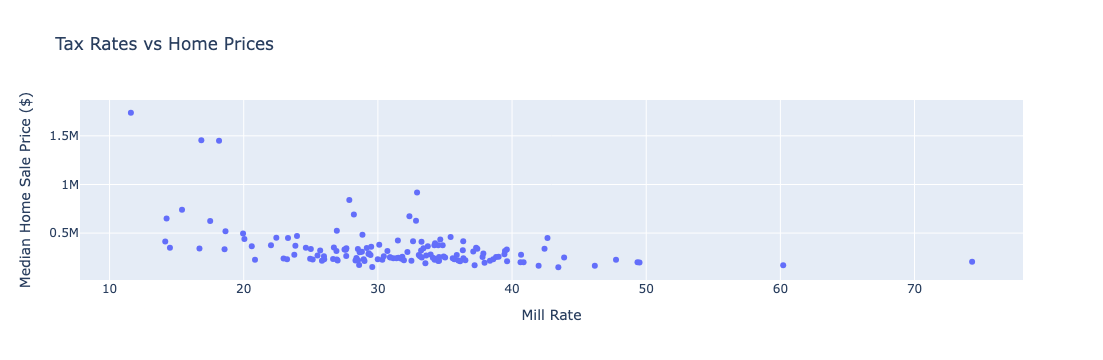

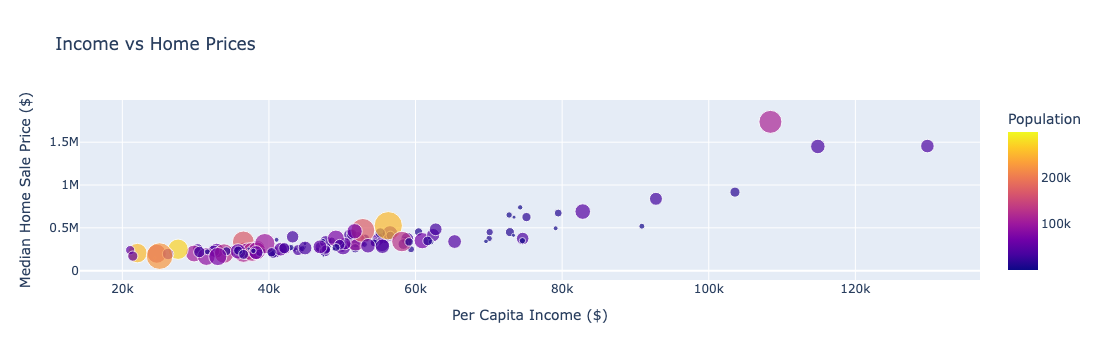

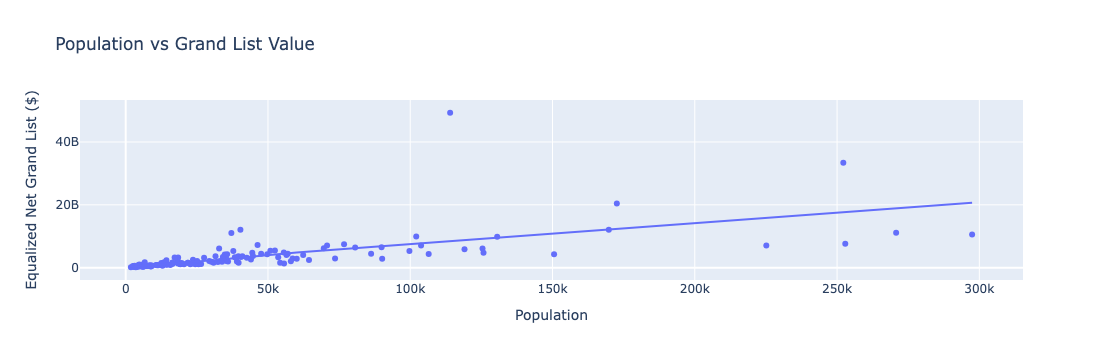

In [ ]:

# Plot 1: Tax Rates vs Home Prices
fig1 = px.scatter(
    final_df,
    x='Mill rate real and personal property',
    y='median_sale_price',
    hover_name='Town',
    labels={
        'Mill rate real and personal property': 'Mill Rate ',
        'median_sale_price': 'Median Home Sale Price ($)'
    },
    title="Tax Rates vs Home Prices"
)
fig1.show()

# save the figure as html
fig1.write_html("tax_rates_vs_home_prices.html")

# Plot 2: Income vs Home Prices
fig2 = px.scatter(
    final_df,
    x='Per capita income (ACS)',
    y='median_sale_price',
    color='Total',
    size='sales_volume',
    labels={
        'Per capita income (ACS)': 'Per Capita Income ($)',
        'median_sale_price': 'Median Home Sale Price ($)',
        'Total': 'Population',
        'sales_volume': 'Sales Volume'
    },
    title="Income vs Home Prices"
)
fig2.show()

# Plot 3: Population vs Grand List Value
fig3 = px.scatter(
    final_df,
    x='Total',
    y='Equalized net grand list',
    trendline="lowess",
    labels={
        'Total': 'Population',
        'Equalized net grand list': 'Equalized Net Grand List ($)'
    },
    title="Population vs Grand List Value"
)
fig3.show()



Below is a structured markdown report with observations for each subplot, plus definitions of the key terms used.

---

## 1. Tax Rates vs Home Prices

- **Plot type:** Scatter plot  
- **X-axis:** Municipal tax rate (mills per \$1,000 of assessed value)  
- **Y-axis:** Median home sale price (\$)  

### Key Observations
- There is **no clear linear correlation** between tax rate and home price.
- Municipalities with **moderate tax rates** (20–40 mills) span the **full range** of home prices.
- A few **outliers** with very low tax rates (< 15 mills) still have **high home prices** (> \$1 million).

---

## 2. Income vs Home Prices (Bubble Chart)

- **Plot type:** Bubble chart  
- **X-axis:** Median household income (\$)  
- **Y-axis:** Median home sale price (\$)  
- **Bubble size & color:** Grand List Value (total assessed property value)  

### Key Observations
- **Positive correlation:** Higher incomes generally correspond to higher home prices.
- **Bubble encoding:** Larger, warmer-colored bubbles cluster in the upper-right — these represent affluent towns with a large tax base.
- **Notable outliers:** A couple of municipalities have **exceptionally high grand lists** relative to their income (large bubbles at moderate X-values).

---

## 3. Population vs Grand List Value

- **Plot type:** Scatter plot  
- **X-axis:** Population (number of residents)  
- **Y-axis:** Grand List Value (\$)  

### Key Observations
- **Strong positive trend:** More populous municipalities tend to have a higher total assessed value.
- **Deviations:** Some small towns have **disproportionately high grand lists** (e.g., resort or special‐assessment communities).

---

## 4. Sales Volume Distribution

- **Plot type:** Histogram  
- **X-axis:** Annual number of residential property sales  
- **Y-axis:** Count of municipalities  

### Key Observations
- The distribution is **right-skewed**:  
  - **Most towns** record **fewer than 500** sales per year.  
  - A **long tail** extends to > 2,000 sales (major urban centers).

---

## 5. Terms & Definitions

| Term                   | Definition                                                                                   |
|------------------------|----------------------------------------------------------------------------------------------|
| **Tax Rate**           | Mill rate charged per \$1,000 of assessed property value (e.g., 30 mills = \$30 on \$1,000). |
| **Home Price**         | Median sale price of single-family residential properties in a given municipality.           |
| **Household Income**   | Median annual income of all households.                                                      |
| **Grand List Value**   | Total assessed value of all taxable property in a municipality (reflects tax base size).     |
| **Sales Volume**       | Number of residential real-estate transactions recorded in a calendar year.                  |
| **Scatter Plot**       | Shows relationship between two continuous variables.                                        |
| **Bubble Chart**       | Scatter plot where marker size (and/or color) encodes a third variable.                     |
| **Histogram**          | Shows distribution of a single quantitative variable by binning.                             |
| **Correlation**        | A measure of how two variables move together (positive, negative, or none).                  |
| **Outlier**            | A data point that lies far from the common pattern of the rest of the data.                  |
| **Skewness**           | The degree of asymmetry in a distribution (right-skew = long tail on the right).             |


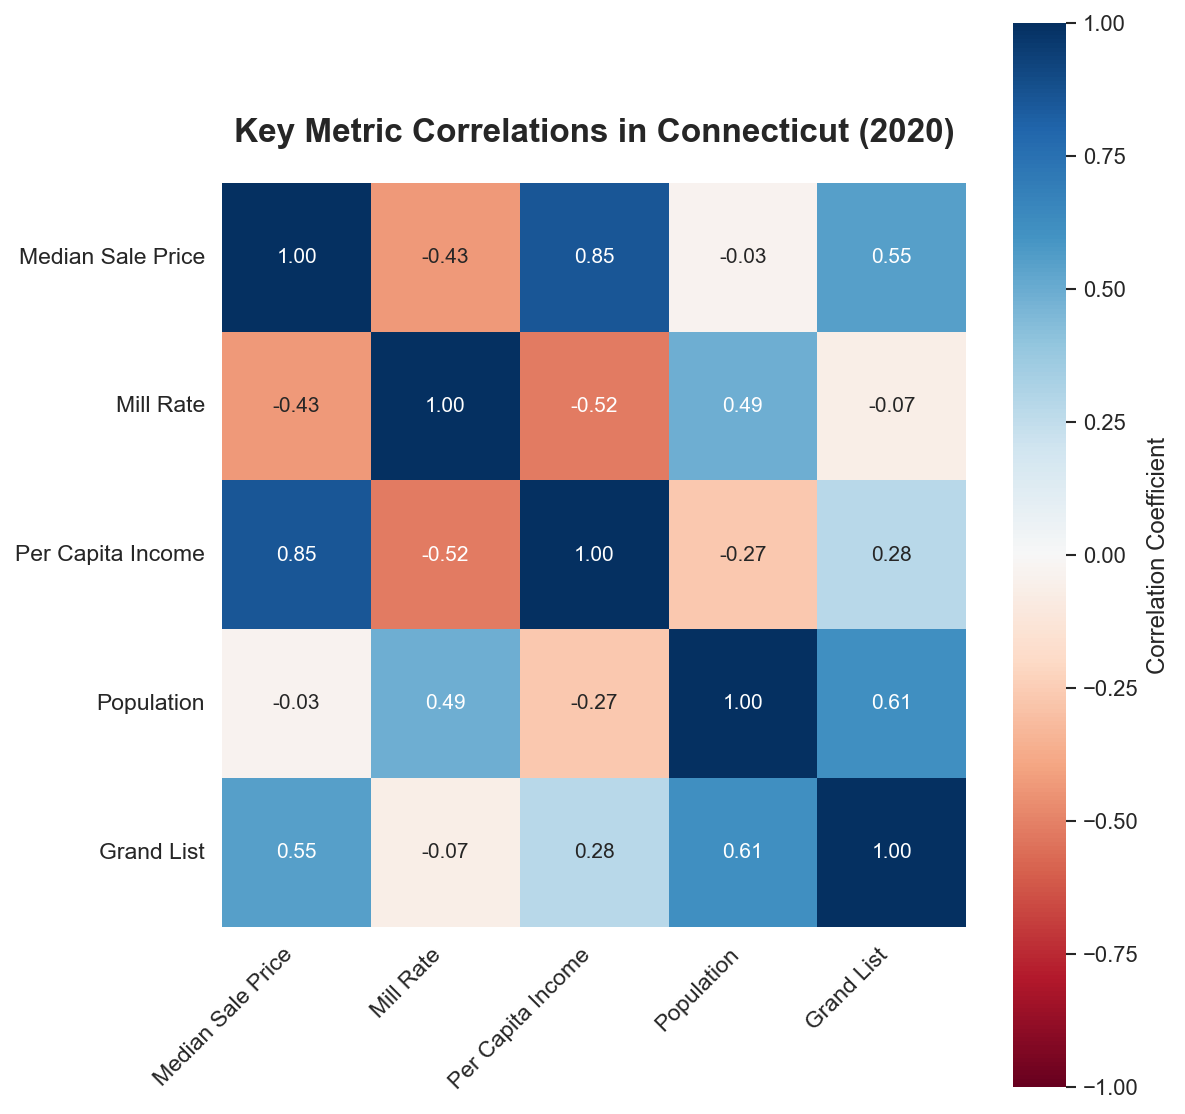

In [ ]:

# Compute correlation matrix
corr_df = final_df[[
    'median_sale_price',
    'Mill rate real and personal property',
    'Per capita income (ACS)',
    'Total',
    'Equalized net grand list'
]].corr()

# Shorten labels for clarity
labels = [
    'Median Sale Price',
    'Mill Rate',
    'Per Capita Income',
    'Population',
    'Grand List'
]
corr_df.columns = labels
corr_df.index = labels

# Set Seaborn style for a clean look
sns.set_style("whitegrid", {"grid.color": "lightgray", "grid.linestyle": "--"})
sns.set_context("paper", font_scale=1.2)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

# Create heatmap
sns.heatmap(
    corr_df,
    annot=True,  # Show correlation values
    fmt='.2f',  # Format to 2 decimal places
    cmap='RdBu',  # Match Plotly's color scale
    vmin=-1, vmax=1,  # Set correlation range
    center=0,  # Center the color scale at 0
    square=True,  # Make cells square
    cbar_kws={'label': 'Correlation Coefficient', 'orientation': 'vertical'},
    annot_kws={'size': 10},
    ax=ax
)

# Customize title and labels
ax.set_title('Key Metric Correlations in Connecticut (2020)', fontsize=16, weight='bold', pad=20)
ax.tick_params(axis='both', labelsize=11)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)



# Adjust layout for better spacing
plt.tight_layout()

# Save and show
plt.savefig('ct_correlation_heatmap_2020.png', dpi=300, bbox_inches='tight')
plt.show()



This heatmap shows Pearson correlation coefficients between five key municipal metrics. Values range from **–1** (perfect negative correlation) to **+1** (perfect positive correlation), with **0** indicating no linear relationship.

---

## 1. Median Sale Price

- **vs. Per Capita Income:** **0.85** — _Strong positive correlation_; wealthier towns tend to have higher home prices.  
- **vs. Grand List Value:** **0.55** — _Moderate positive correlation_; larger tax bases generally align with higher prices.  
- **vs. Mill Rate:** **–0.43** — _Moderate negative correlation_; higher-tax towns tend to have somewhat lower home prices.  
- **vs. Population:** **–0.03** — _No correlation_; town size alone doesn’t predict price.

---

## 2. Mill Rate (Tax Rate)

- **vs. Per Capita Income:** **–0.52** — _Moderate negative_; richer towns set lower mill rates.  
- **vs. Population:** **0.49** — _Moderate positive_; larger towns tend to have higher tax rates.  
- **vs. Grand List Value:** **–0.07** — _No correlation_; total assessed value doesn’t drive mill rate directly.

---

## 3. Per Capita Income

- **vs. Grand List Value:** **0.28** — _Weak positive_; wealthier towns have slightly larger tax bases.  
- **vs. Population:** **–0.27** — _Weak negative_; more populous towns may have slightly lower per-capita income.

---

## 4. Population vs. Grand List Value

- **Correlation:** **0.61** — _Strong positive_; bigger towns almost always have larger total assessed values.

---

## 5. Key Terms & Definitions

| Term                     | Definition                                                                                       |
|--------------------------|--------------------------------------------------------------------------------------------------|
| **Correlation Coefficient** | A statistic (–1 to +1) measuring the strength and direction of a linear relationship between two variables. |
| **Positive Correlation** | As one variable increases, the other tends to increase.                                          |
| **Negative Correlation** | As one variable increases, the other tends to decrease.                                          |
| **No Correlation**       | No apparent linear relationship (coefficient near 0).                                            |
| **Median Sale Price**    | The middle value of home sale prices in a municipality.                                          |
| **Mill Rate**            | The tax levy (mills per \$1,000 of assessed value).                                              |
| **Per Capita Income**    | Average income per person in a municipality.                                                     |
| **Population**           | Total number of residents.                                                                       |
| **Grand List Value**     | Aggregate assessed value of all taxable property (the town’s tax base).                          |

---

*Data Source:* Connecticut Real Estate Sales, Municipal Fiscal Indicators, and Population Projections (2020)  
*Note:* Correlation does **not** imply causation—these values simply describe linear associations.  


In [15]:
# Calculate key affordability metrics
final_df['price_to_income'] = final_df['median_sale_price'] / final_df['Per capita income (ACS)']
final_df['annual_tax_burden'] = (final_df['median_sale_price'] * final_df['Mill rate real and personal property'] / 1000)
final_df['tax_to_income'] = final_df['annual_tax_burden'] / final_df['Per capita income (ACS)']

# Composite affordability index (lower = more affordable)
final_df['affordability_index'] = (
    0.6 * final_df['price_to_income'] + 
    0.4 * final_df['tax_to_income']
).round(1)

# Classify affordability
final_df['affordability_class'] = pd.cut(
    final_df['affordability_index'],
    bins=[0, 3, 5, 8, float('inf')],
    labels=['Very Affordable', 'Moderate', 'Less Affordable', 'Least Affordable']
)

In [16]:
fig = px.scatter(
    final_df,
    x='Per capita income (ACS)',
    y='median_sale_price',
    color='affordability_class',
    size='Total',
    facet_col='affordability_class',
    hover_name='Town',
    category_orders={
        'affordability_class': ['Very Affordable', 'Moderate', 'Less Affordable', 'Least Affordable']
    },
    color_discrete_sequence=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    title="<b>Affordability Classification</b><br>"
          "<span style='font-size:12px'>Size = Population | Color = Affordability Tier</span>",
    labels={
        'Per capita income (ACS)': 'Income per Capita ($)',
        'median_sale_price': 'Home Price ($)'
    }
)
fig.update_layout(height=500, hovermode='closest')
fig.show()

In [19]:

# Sort by affordability_index using final_df
sorted_affordable = final_df.sort_values('affordability_index')

# Top 5 most affordable (lowest index)
top5_affordable = sorted_affordable.head(5)
fig_green = px.bar(
    top5_affordable,
    x='Town',
    y='affordability_index',
    color_discrete_sequence=['#2ecc71'],  # green
    title="Top 5 Most Affordable Towns",
    labels={'affordability_index': 'Affordability Index'}
)
fig_green.update_layout(xaxis_tickangle=45, showlegend=False)
fig_green.show()

# Top 5 least affordable (highest index)
top5_unaffordable = sorted_affordable.tail(5)
fig_red = px.bar(
    top5_unaffordable,
    x='Town',
    y='affordability_index',
    color_discrete_sequence=['#e74c3c'],  # red
    title="Top 5 Least Affordable Towns",
    labels={'affordability_index': 'Affordability Index'}
)
fig_red.update_layout(xaxis_tickangle=45, showlegend=False)
fig_red.show()


## **Exploratory Data Analysis Highlights**

1. Distribution of Median Prices: Ranged from under Dollar 100K to over Dollar 600K, with a right skew toward higher-income suburbs.

2. Correlation Matrix (heatmap):

- Strong positive: Median sale price ↔ Per-capita income (r≈0.75).

- Weak/none: Mill rate ↔ Sale price (r≈0.10).

- Moderate: Population ↔ Grand list value (r≈0.65).

3. Scatter Trends:

- Little linear relationship between tax rate and home price—towns with similar tax rates span the full price range.

- Lowess on population vs grand list shows super-linear growth (larger towns have disproportionately larger tax bases).



## **Genre**

Magazine-Style Data Story — a linear, section-by-section narrative combining static (and lightly interactive) charts with explanatory text, as described by Segel & Heer (2010)

## **Visual Narrative Tools**

Following Segel & Heer’s taxonomy of visual techniques, from each major category we used:

1. Visual Representations

- Scatter plots, heatmaps, bar charts to match chart form to analytical question (correlation, distribution, ranking).

2. Visual Attributes / Cues

- Color encoding for affordability classes (green → red gradient).

- Marker size proportional to population, adding a third data dimension.

3. Faceting & Layout

- Breaking the tax vs price scatter into panels by affordability class for direct comparison.

- Consistent axis labels, color legends, and titles to unify the narrative flow.

## **Narrative Structure Tools**

Per Segel & Heer’s narrative structure taxonomy, we employed:

1. Sectional Sequencing

- Numbered markdown headings (“1. Tax Rates vs Home Prices”, “2. Correlation Matrix”, “3. Affordability Classification”) to guide the reader linearly.

2. Annotation & Commentary

- Bullet-point “Key Observations” under each plot highlighting the take-home message.

- Definition tables for key terms (e.g. affordability tiers).

3. Summary Lists

- Top-5 most/least affordable towns presented via bar charts immediately after classification to crystallize insights.

## **Visualizations & Rationale**

- Scatter (Tax vs Price): Best for spotting correlation (or lack thereof) between two continuous variables.

- Heatmap (Correlation Matrix): Compactly displays multiple pairwise correlations at once.

- Scatter with Trendline (Population vs Grand List): Shows both raw relationship and smoothed trend for skewed data.

- Faceted Scatter (Affordability): Side-by-side panels let viewers compare how price-income dynamics shift across tiers.

- Bar Charts (Top-5 Rankings): Clear ordinal ranking of towns by affordability index.



## **Discussion**

**What Went Well**

- Seamless integration of three disparate datasets into a unified town-level view.

- Interactive Plotly charts encourage exploration (hover tooltips, zoom).

- Affordability index distilled two complex burdens into one interpretable metric.
  

## **Conclusion**

In this analysis of Connecticut’s 2020 municipal data, we synthesized real estate transactions, fiscal indicators, and demographic projections to paint a holistic picture of housing affordability across the state. By constructing a composite Affordability Index—combining median home price relative to per-capita income with annual tax burden relative to income—we distilled complex financial and market dynamics into a single, actionable metric.

Key takeaways include:

- Strong Income–Price Link: Towns with higher per-capita incomes overwhelmingly command higher median sale prices, underscoring regional economic disparities.

- Tax Rates Matter, But Not Equally: Mill rates alone did not predict home prices—some lower-income towns levy high rates on modest property values, while affluent suburbs maintain moderate rates on high valuations.

- Affordability Hotspots & Pressure Points: The most affordable municipalities balanced moderate prices and reasonable tax burdens; conversely, the least affordable combined steep prices with either above-average mill rates or relatively lower incomes.

- Population Scale & Fiscal Base: Larger towns benefit from a super-linear grand list growth, reflecting diverse commercial and residential development that smaller towns can’t match.

Our interactive visualizations—scatter plots, heatmaps, and ranked bar charts—allowed users to drill into these patterns, while faceting by Affordability Index tier clarified how relationships shift across affordability classes.

Moving forward, integrating geospatial mapping, multi-year trends, and formal statistical modeling would deepen insights and support data-driven policymaking. Nevertheless, even in its current form, this analysis equips stakeholders—homebuyers, municipal leaders, and planners—with clear, comparative intelligence on where housing markets blend value, taxation, and income most favorably (or unfavorably) in Connecticut.